In [1]:
# project: p6
# submitter: chen2328
# partner: none
# hours: 6

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.mask import mask

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline   
from sklearn.compose import make_column_transformer 
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn import preprocessing

In [3]:
counties_df = gpd.read_file("counties.geojson")
counties_df.head()

,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."


In [4]:
tracts_df = gpd.read_file("tracts.geojson")
tracts_df.head()

,GEOID,POP100,geometry
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02628 44.086..."
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15011 44.509..."
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53920 44.327..."
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.93742 44.630..."
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.06830 44.453..."


### Q1: How many counties are in Wisconsin?

In [5]:
#q1
len(counties_df.groupby('NAME').count())

72

### Q2: What is the population of each county in WI?

<AxesSubplot:>

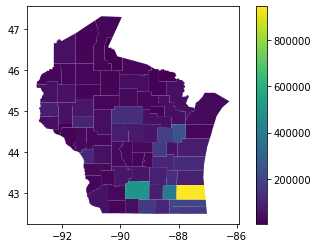

In [6]:
#q2
counties_df.plot(column="POP100", legend=True)

### Q3: What are the counties in the test dataset?

In [7]:
import sqlite3

# creating a connection object that represents the database
# cursor 
conn = sqlite3.connect("counties_tracts.db")

In [8]:
# Show all the tables the DB has
pd.read_sql("""SELECT * FROM sqlite_master""", conn)

,type,name,tbl_name,rootpage,sql
0,table,counties,counties,2,"CREATE TABLE ""counties"" (\n""index"" INTEGER,\n ..."
1,index,ix_counties_index,counties,3,"CREATE INDEX ""ix_counties_index""ON ""counties"" ..."
2,table,tracts,tracts,4,"CREATE TABLE ""tracts"" (\n""index"" INTEGER,\n ""..."
3,index,ix_tracts_index,tracts,5,"CREATE INDEX ""ix_tracts_index""ON ""tracts"" (""in..."


In [9]:
pd.read_sql("""SELECT * FROM counties LIMIT 5""", conn)

,index,NAME,COUNTY,AREALAND,AREAWATER
0,0,Racine County,101,861533739,1190103013
1,1,Clark County,019,3133378070,23239614
2,2,Wood County,141,2054044751,41994799
3,3,Rusk County,107,2366092584,44813690
4,4,Ozaukee County,089,603514413,2287415379


In [10]:
arealand_df = pd.read_sql("""SELECT AREALAND FROM counties""", conn)
counties_df['AREALAND'] = arealand_df['AREALAND']
counties_df.head()

,NAME,POP100,geometry,AREALAND
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413


In [11]:
# random state, so we do not get differeent outcome everytime 
# still need cross validation to see stable ??
train, test = train_test_split(counties_df, random_state=320, test_size=0.25)

In [12]:
#q3
test['NAME'].to_list()

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

### Q4: How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?

In [13]:
#q4
model = LinearRegression()
model.fit(train[["AREALAND"]], train['POP100'])
model.score(test[["AREALAND"]], test['POP100'])

0.022002661530554857

### Q5: What is the predicted population of a county with 500 square miles of area, according to the model?

In [14]:
#q5
# Do we always need to create a datafrane and predict???
# So always create a dataframe
meters = 500 * 2.59e+6
predict_df_5 = pd.DataFrame({'AREALAND': [meters]})
predict_df_5
predict_df_5['predicted_y'] = model.predict(predict_df_5)
predict_df_5['predicted_y'].iloc[0]

82032.53073541154

In [58]:
predict_df_5['predicted_y'] = model.predict([[500 * 2.59e+6]])

/home/chenyenchun/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Part 2: Predicting Population using Housing Units

### Q6: What are the counties in the test dataset?

In [15]:
pd.read_sql("""SELECT * FROM tracts""", conn)

,index,NAME,COUNTY,HU100
0,0,Census Tract 9701.01,085,2760
1,1,Census Tract 9710.01,085,1536
2,2,Census Tract 9706.01,085,1208
3,3,Census Tract 9706.02,085,3136
4,4,Census Tract 4301,131,2144
...,...,...,...,...
1404,1404,Census Tract 14,059,2913
1405,1405,Census Tract 15,059,1550
1406,1406,Census Tract 16,059,1286
1407,1407,Census Tract 17,059,1068


In [16]:
pd.read_sql("""SELECT * FROM counties LIMIT 5""", conn)

,index,NAME,COUNTY,AREALAND,AREAWATER
0,0,Racine County,101,861533739,1190103013
1,1,Clark County,019,3133378070,23239614
2,2,Wood County,141,2054044751,41994799
3,3,Rusk County,107,2366092584,44813690
4,4,Ozaukee County,089,603514413,2287415379


In [17]:
hu100_df = pd.read_sql("""
SELECT c.NAME, c.COUNTY, SUM(HU100) HU100
FROM counties c
JOIN tracts t
ON c.COUNTY = t.COUNTY
GROUP BY c.COUNTY""", conn)
hu100_df

,NAME,COUNTY,HU100
0,Adams County,001,17436
1,Ashland County,003,9656
2,Barron County,005,23614
3,Bayfield County,007,12999
4,Brown County,009,104371
...,...,...,...
67,Waukesha County,133,160864
68,Waupaca County,135,25396
69,Waushara County,137,14843
70,Winnebago County,139,73329


In [18]:
# merge two table
counties_df = pd.merge(counties_df, hu100_df, how='inner', on='NAME')
counties_df.head()

,NAME,POP100,geometry,AREALAND,COUNTY,HU100
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,101,82164
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,019,15076
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751,141,34088
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584,107,8883
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413,089,36267


In [19]:
counties_df.drop(columns=['COUNTY'], inplace=True)
counties_df.head()

,NAME,POP100,geometry,AREALAND,HU100
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,82164
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,15076
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751,34088
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584,8883
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413,36267


In [20]:
#q6
train, test = train_test_split(counties_df, 
                               random_state=320, 
                               test_size=0.25)
test['NAME'].to_list()

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [21]:
train.head()

,NAME,POP100,geometry,AREALAND,HU100
23,Walworth County,102228,"POLYGON ((-88.31128 42.49462, -88.31122 42.494...",1438458152,51531
42,Marquette County,15404,"POLYGON ((-89.24491 43.76691, -89.24484 43.767...",1180045997,9896
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,82164
34,Waupaca County,52410,"POLYGON ((-88.73634 44.67907, -88.73717 44.679...",1936517317,25396
60,Lincoln County,28743,"POLYGON ((-89.42532 45.20608, -89.42532 45.206...",2276189610,16784


### Q7: What are the HU100 values for the counties in the train dataset?


In [22]:
#q7
dict(zip(train.NAME, train.HU100))

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

### Q8: How much variance in the POP100 can a LinearRegression model explain based only on HU100?

In [23]:
#q8
model = LinearRegression()
model.fit(train[["HU100"]], train['POP100'])
score = cross_val_score(model, train[["HU100"]], train['POP100'])
score.mean()

0.9652534544116037

### Q9: What is the standard deviation of the cross validation scores from Q7?

In [24]:
#q9
score.std()

0.03704265206670459

### Q10: What is the formula relating POP100 and HU100?

In [25]:
#q10
f"POP100 = {round(model.coef_[0], 2)}*HU100 + {round(model.intercept_, 2)}"

'POP100 = 2.39*HU100 + -7910.46'

In [26]:
predict_df = pd.DataFrame({'HU100': counties_df['HU100']})
predict_df['predicted_y'] = model.predict(predict_df)
predict_df

,HU100,predicted_y
0,82164,188135.442324
1,15076,28061.355663
2,34088,73424.588068
3,8883,13284.662086
4,36267,78623.750882
...,...,...
67,12979,23057.847439
68,19204,37910.894027
69,8868,13248.871613
70,11120,18622.214732


### Q11: What is the relationship between HU100 and POP100, visually?

In [27]:

# ax = predict_df.plot.line(x='HU100', y='predicted_y', color='red', label='Predicted')
# counties_df.plot.scatter(x='HU100', y='POP100', ax=ax, color='blue', label='Actual')

# dane_hu = counties_df[counties_df['NAME']=='Dane County'].HU100
# dane_pop = counties_df[counties_df['NAME']=='Dane County'].POP100
# ax.text(dane_hu, dane_pop, '  Dane', va='center', ha='left')

Text(59    216022
Name: HU100, dtype: int64, 59    488073
Name: POP100, dtype: int64, ' Dane')

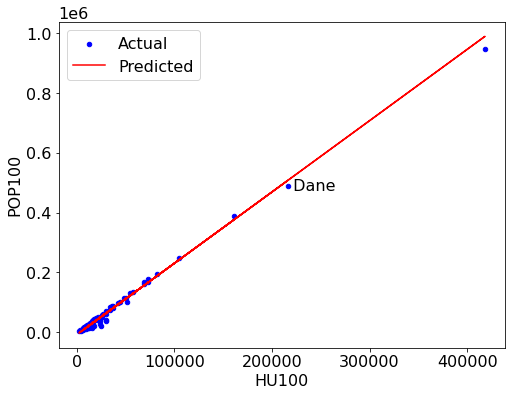

In [28]:
#q11
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(figsize=(8, 6))
counties_df.plot.scatter(x='HU100', y='POP100', ax=ax, color='blue', label='Actual')
predict_df.plot.line(x='HU100', y='predicted_y', color='red', label='Predicted', ax=ax)


dane_hu = counties_df[counties_df['NAME']=='Dane County'].HU100
dane_pop = counties_df[counties_df['NAME']=='Dane County'].POP100
ax.text(dane_hu, dane_pop, ' Dane', va='center', ha='left')

### Q12: How many numbers in matrix A are between 2 and 5 (inclusive)?

In [29]:
#q12
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
len(A[(A<=5) * (A>=2)])

12

### Q13: How does Milwaukee County look?

In [30]:
milwaukee_df = counties_df[counties_df["NAME"] == 'Milwaukee County']
milwaukee_df

,NAME,POP100,geometry,AREALAND,HU100
15,Milwaukee County,947735,"POLYGON ((-87.82631 42.84223, -87.82418 42.842...",625435295,418053


In [31]:
land = rasterio.open("zip://../p6/land.zip!wi.tif")

In [32]:
matrix, _ = mask(land, milwaukee_df.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

In [33]:
matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [34]:
from matplotlib.colors import ListedColormap

# what is this matric for ???

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

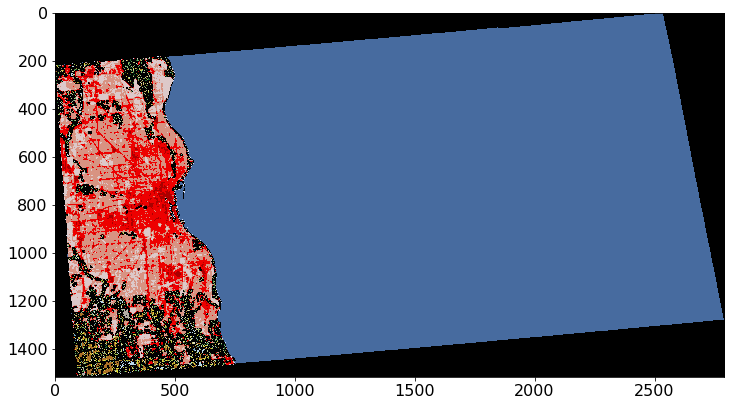

In [35]:
#q13
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)

In [36]:
#plt.imshow(matrix, cmap=custom_cmap)

### Q14: What portion of Milwaukee County is "Open Water"?

In [37]:
matrix == 11

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [38]:
#q14
(matrix == 11).astype(int).sum() / (matrix > 0).astype(int).sum()

0.7963037455950543

In [39]:
counties_df.head()

,NAME,POP100,geometry,AREALAND,HU100
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,82164
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,15076
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751,34088
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584,8883
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413,36267


### Q15: What is the Relationship Between POP100 and  and ___grassland____ ?

Text(0.5, 1.0, 'Relationship Between POP100 and GRASSLAND')

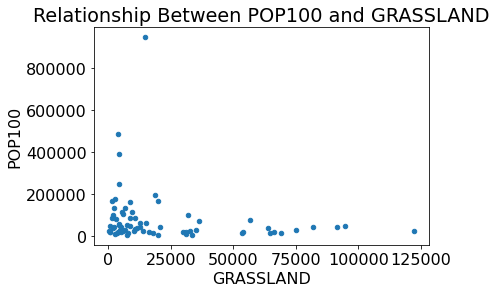

In [40]:
#q15
# the Relationship Between POP100 and ___grassland____

# always create a empty list first, is there another way to do?
dict_15 = {'NAME': [], 'POP100': [], 'PASTURE_TYPE': [], 'GRASSLAND': []}
land = rasterio.open("zip://../p6/land.zip!wi.tif")

for i in range(len(counties_df['NAME'])):
    name = counties_df['NAME'].iloc[i]
    dict_15['NAME'].append(name)
    dict_15['POP100'].append(counties_df['POP100'].iloc[i])
    
    county_df = counties_df[counties_df["NAME"] == name]
    matrix, _ = mask(land, county_df.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    pasture = (matrix == 81).astype(int).sum()
    grass = (matrix == 71).astype(int).sum()
    dict_15['PASTURE_TYPE'].append(pasture)
    dict_15['GRASSLAND'].append(grass)

ax = pd.DataFrame(dict_15).plot.scatter(x='GRASSLAND', y='POP100')
ax.set_title("Relationship Between POP100 and GRASSLAND")

Text(0.5, 1.0, 'Relationship Between POP100 and PASTURE_TYPE')

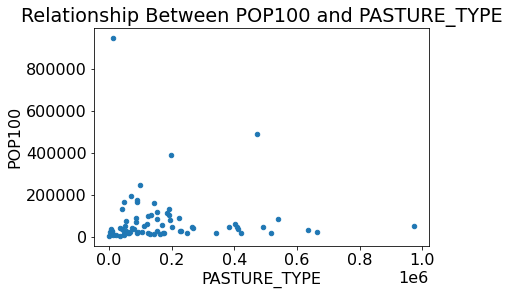

In [41]:
ax = pd.DataFrame(dict_15).plot.scatter(x='PASTURE_TYPE', y='POP100')
ax.set_title("Relationship Between POP100 and PASTURE_TYPE")

### Individual Part

In [42]:
tracts_df.head()

,GEOID,POP100,geometry
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02628 44.086..."
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15011 44.509..."
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53920 44.327..."
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.93742 44.630..."
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.06830 44.453..."


In [43]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}


In [44]:
tracts_dict = {
    'GEOID': tracts_df['GEOID'].to_list(),
    'POP100': tracts_df['POP100'].to_list(),
}

for key in land_use:
    tracts_dict[key] = []


In [45]:

for i in range(len(tracts_df['GEOID'])):
    geo_id = tracts_df['GEOID'].iloc[i]
    tract_df = tracts_df[tracts_df["GEOID"] == geo_id]
    matrix, _ = mask(land, tract_df.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    
    for key in tracts_dict:
        if key in land_use:
            land_num = land_use[key]
            value = (matrix == land_num).astype(int).sum()
            tracts_dict[key].append(value)
    

In [46]:
train_data = pd.DataFrame(tracts_dict)

In [47]:
train_data.head()

,GEOID,POP100,open_water,ice_snow,developed_open,developed_low,developed_med,developed_high,barren,deciduous,...,dwarf_scrub,shrub_scrub,grassland,sedge,lichens,moss,pasture,crops,woody_wetlands,herbacious_wetlands
0,55001950204,1646,55465,0,12351,5402,833,104,175,62714,...,0,18518,33652,0,0,0,3136,73433,84766,20975
1,55009940002,4698,57,0,1456,2104,1211,243,229,2619,...,0,23,38,0,0,0,770,1503,2317,123
2,55061990000,0,2107187,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,55009020100,5817,117008,0,6209,7738,1971,337,718,6347,...,0,60,327,0,0,0,17419,112681,26017,2677
4,55009010100,6506,530,0,1141,2711,1109,174,2,0,...,0,0,52,0,0,0,23,2,79,47


In [48]:
train, test = train_test_split(train_data, 
                               random_state=320, 
                               test_size=0.25)


In [49]:
features = train.columns
features

Index(['GEOID', 'POP100', 'open_water', 'ice_snow', 'developed_open',
       'developed_low', 'developed_med', 'developed_high', 'barren',
       'deciduous', 'evergreen', 'mixed_forest', 'dwarf_scrub', 'shrub_scrub',
       'grassland', 'sedge', 'lichens', 'moss', 'pasture', 'crops',
       'woody_wetlands', 'herbacious_wetlands'],
      dtype='object')

In [50]:
features_cols = ['open_water', 'ice_snow', 'developed_open',
       'developed_low', 'developed_med', 'developed_high', 'barren',
       'deciduous', 'evergreen', 'mixed_forest', 'dwarf_scrub', 'shrub_scrub',
       'grassland', 'sedge', 'lichens', 'moss', 'pasture', 'crops',
       'woody_wetlands', 'herbacious_wetlands']

In [51]:
# candidate 1
trans_1 = make_column_transformer(
    (preprocessing.StandardScaler(), features_cols)
)
trans_1

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['open_water', 'ice_snow', 'developed_open',
                                  'developed_low', 'developed_med',
                                  'developed_high', 'barren', 'deciduous',
                                  'evergreen', 'mixed_forest', 'dwarf_scrub',
                                  'shrub_scrub', 'grassland', 'sedge',
                                  'lichens', 'moss', 'pasture', 'crops',
                                  'woody_wetlands', 'herbacious_wetlands'])])

In [52]:
# candidate 1
model1 = Pipeline([
    ("trans", trans_1),
    ("lr", LinearRegression()),
])
model1

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['open_water', 'ice_snow',
                                                   'developed_open',
                                                   'developed_low',
                                                   'developed_med',
                                                   'developed_high', 'barren',
                                                   'deciduous', 'evergreen',
                                                   'mixed_forest',
                                                   'dwarf_scrub', 'shrub_scrub',
                                                   'grassland', 'sedge',
                                                   'lichens', 'moss', 'pasture',
                                                   'crops', 'woody_wetlands',
                    

In [53]:
cross_val_score(model1, train[features_cols], train['POP100']).mean()

0.5009996034189181

In [54]:
# candidate 2
model2 = LinearRegression()
cross_val_score(model2, train[['developed_open','developed_low', 'developed_med']],
                train['POP100']).mean()

0.4049894565296882

### Q16: How do the models you selected compare under cross validation?


Text(0.5, 1.0, 'Model Performance')

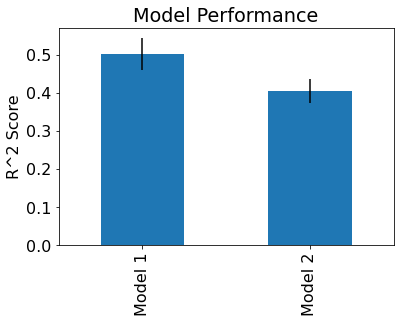

In [55]:
#q16
scores1 = cross_val_score(model1, train[features_cols], train['POP100'])
scores2 = cross_val_score(model2, train[['developed_open','developed_low', 'developed_med']], 
                      train['POP100'])

avg = pd.Series({"Model 1": scores1.mean(), "Model 2": scores2.mean()})
std = pd.Series({"Model 1": scores1.std(), "Model 2": scores2.std()})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")
ax.set_title("Model Performance")

### Q17: How does your recommended model score against the test dataset?

In [56]:
#q17
# Reason why choosing my first model 
# 1. Higher accuracy 
# 2. The variance of accuracy score in model1 is higher than model2
model1.fit(train[features_cols], train['POP100'])
model1.score(test[features_cols], test['POP100'])

0.4486728541665782